In [11]:
import pandas as pd
import numpy as np

# データ取得

In [12]:
data = pd.read_csv('data/train.csv')

In [13]:
data = data[['jap_question_1_wakati', 'jap_question_2_wakati', 'is_duplicate']]

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 3 columns):
jap_question_1_wakati    24000 non-null object
jap_question_2_wakati    24000 non-null object
is_duplicate             24000 non-null int64
dtypes: int64(1), object(2)
memory usage: 562.6+ KB


### 以下のように入力文をjoinする  
[PAD] (input1) [SEP] (input2) [CLS]

In [15]:
data['input'] = '[PAD] ' + data['jap_question_1_wakati'] + ' [SEP] ' + data["jap_question_2_wakati"] + ' [CLS]'
X = data[['input']]
y = data[['is_duplicate']]

In [16]:
X.head()

,input
0,[PAD] 私 たち 自身 の 国 の を 開始 する ため の 手順 は 何 です か ？...
1,[PAD] どの よう に 私 は 私 が 紹介 し て 結論 を ​​ 書く べき 100...
2,[PAD] ジャイプール で 最高 の CLAT コーチング 研究所 は どれ です か ？...
3,[PAD] 第 三 次 世界 大戦 が 来 て い ます か ？ [SEP] 我々 は 世...
4,[PAD] なぜ NASA や ソ連 による いかなる さら なる 月面 着陸 が 行わ れ...


### 最大文字長の指定

In [17]:
%matplotlib inline

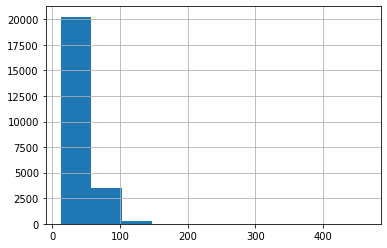

In [18]:
# 分布の確認
X['input'].apply(lambda x: len(x.split(' '))).hist()

In [19]:
max_sentence_length = 200

In [20]:
# 最大文字長以上のデータを削除
condition = X['input'].apply(lambda x: len(x.split(' '))) <= max_sentence_length
X = X[condition]
y = y[condition]

In [21]:
print(X.shape)
print(y.shape)

(23996, 1)
(23996, 1)


### 他のモデルと性能を比較するために単語辞書は別で定義しておく
注: BERTと比較したいので、BERTのpretrainedモデルの辞書を使用

In [22]:
with open('vocab.txt', 'r') as f:
    vocab = f.read()

In [23]:
id2vocab = {i: val for i, val in enumerate(vocab.split('\n'))}
vocab2id = {g: f for f, g in id2vocab.items()}

In [24]:
def replace_id(text):
    return " ".join([str(vocab2id.get(f, vocab2id['[UNK]'])) for f in text.split(" ")])

X = X.assign(
    input=lambda df: df['input'].apply(replace_id)
)

In [25]:
X_list = [[int(g) for g in f.split(' ')] for f in X['input'].to_list()]

### ゼロ埋め
全ての入力文が最大文字長になるように足りない文字数だけゼロ埋め

In [26]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [27]:
X_pre = pad_sequences(X_list, maxlen=max_sentence_length)

In [28]:
y_pre = pd.get_dummies(y['is_duplicate']).to_numpy()

# model
LSTMを使用

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Embedding
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [49]:
num_words = len(id2vocab)
emb_dim = 128
num_labels = 2
n_hidden = 200

def make_model(len_seq, emb_dim, num_labels, n_hidden):
    model = Sequential()
    model.add(Embedding(num_words, emb_dim, input_length=len_seq))
    model.add(LSTM(n_hidden, batch_input_shape=(None, len_seq, emb_dim), return_sequences=False))
    model.add(Dense(num_labels))
    model.add(Activation("sigmoid"))
    return model

model = make_model(
    len_seq=max_sentence_length,
    emb_dim=emb_dim,
    num_labels=num_labels,
    n_hidden=n_hidden
)

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          4096768   
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 4,360,370
Trainable params: 4,360,370
Non-trainable params: 0
_________________________________________________________________


# train and evaluation

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y_pre, shuffle=True, random_state=123)

In [53]:
optimizer = Adam(lr=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['acc'])

In [54]:
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.1)

Train on 16197 samples, validate on 1800 samples
Epoch 1/5
16197/16197 [==============================] - 368s 23ms/step - loss: 0.6088 - acc: 0.6762 - val_loss: 0.5897 - val_acc: 0.7022
Epoch 2/5
16197/16197 [==============================] - 409s 25ms/step - loss: 0.5154 - acc: 0.7592 - val_loss: 0.5945 - val_acc: 0.6869
Epoch 3/5
16197/16197 [==============================] - 378s 23ms/step - loss: 0.4554 - acc: 0.7997 - val_loss: 0.6377 - val_acc: 0.6761
Epoch 4/5
16197/16197 [==============================] - 377s 23ms/step - loss: 0.4052 - acc: 0.8264 - val_loss: 0.6246 - val_acc: 0.6967
Epoch 5/5
16197/16197 [==============================] - 371s 23ms/step - loss: 0.3605 - acc: 0.8488 - val_loss: 0.7782 - val_acc: 0.6664
